In [28]:
from pathlib import Path
from sklearn.mixture import GaussianMixture
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# Configure notebook and get raw data

In [29]:
data_path = Path("../../data/MACH_data/data.cleaned.csv")
codebook_path = Path("../../data/MACH_data/codebook.txt")
original_data_df = pd.read_csv(data_path)

# Choose features
Sticking to just the actual question response for now.

In [30]:
question_responses = ["Q1A", "Q2A", "Q3A", "Q4A", "Q5A", "Q6A", "Q7A", "Q8A", "Q9A", "Q10A", 
                      "Q11A", "Q12A", "Q13A", "Q14A", "Q15A", "Q16A", "Q17A", "Q18A", "Q19A", "Q20A"]
X = original_data_df[question_responses].copy()
print(f"Using features: {question_responses}  |  Shape: {X.shape}")
display(X.head())

Using features: ['Q1A', 'Q2A', 'Q3A', 'Q4A', 'Q5A', 'Q6A', 'Q7A', 'Q8A', 'Q9A', 'Q10A', 'Q11A', 'Q12A', 'Q13A', 'Q14A', 'Q15A', 'Q16A', 'Q17A', 'Q18A', 'Q19A', 'Q20A']  |  Shape: (73489, 20)


,Q1A,Q2A,Q3A,Q4A,Q5A,Q6A,Q7A,Q8A,Q9A,Q10A,Q11A,Q12A,Q13A,Q14A,Q15A,Q16A,Q17A,Q18A,Q19A,Q20A
0,3.0,3.0,5.0,2.0,3.0,1.0,2.0,4.0,3.0,3.0,1.0,5.0,4.0,1.0,5.0,2.0,4.0,4.0,4.0,4.0
1,5.0,5.0,1.0,3.0,5.0,1.0,1.0,4.0,2.0,1.0,1.0,5.0,5.0,2.0,5.0,1.0,2.0,4.0,5.0,3.0
2,5.0,5.0,1.0,1.0,5.0,1.0,1.0,5.0,1.0,1.0,1.0,5.0,5.0,1.0,5.0,1.0,1.0,5.0,5.0,3.0
3,2.0,4.0,2.0,1.0,5.0,1.0,3.0,2.0,4.0,2.0,1.0,5.0,1.0,1.0,4.0,1.0,1.0,5.0,3.0,4.0
4,5.0,5.0,2.0,1.0,2.0,1.0,2.0,4.0,2.0,2.0,1.0,4.0,4.0,1.0,5.0,1.0,1.0,4.0,5.0,1.0


# Data preprocessing
Scaling this data is likely not necessary since the data is usually between 1 and 5, with some NA values.

In [31]:
X_clean = X.dropna().copy()
X_clean[question_responses] = X_clean[question_responses].astype(int)
Xs = pd.DataFrame(X_clean, columns=question_responses, index=X_clean.index)
# use only 5000 random datapoints
Xs_sample = Xs.sample(n=5000, random_state=42)
print(f"After preprocessing shape: {Xs_sample.shape}")
display(Xs_sample.head())
display(Xs_sample.describe().T.round(3))

After preprocessing shape: (5000, 20)


,Q1A,Q2A,Q3A,Q4A,Q5A,Q6A,Q7A,Q8A,Q9A,Q10A,Q11A,Q12A,Q13A,Q14A,Q15A,Q16A,Q17A,Q18A,Q19A,Q20A
5860,2,1,3,4,4,3,2,2,3,3,3,4,5,3,5,3,1,5,4,4
61638,4,1,1,1,1,1,1,1,5,4,1,5,1,4,5,1,5,1,5,2
33684,5,5,2,3,5,2,2,2,1,4,1,5,4,2,3,2,2,5,5,5
32572,2,4,3,4,2,3,4,2,3,5,1,5,2,1,2,2,1,4,5,4
2493,2,4,4,2,3,3,3,4,5,4,2,2,1,2,3,3,2,4,3,4


,count,mean,std,min,25%,50%,75%,max
Q1A,5000.0,3.318,1.516,1.0,2.0,4.0,5.0,5.0
Q2A,5000.0,3.312,1.473,1.0,2.0,4.0,5.0,5.0
Q3A,5000.0,2.800,1.432,1.0,2.0,3.0,4.0,5.0
Q4A,5000.0,2.766,1.416,1.0,1.0,3.0,4.0,5.0
Q5A,5000.0,3.626,1.346,1.0,3.0,4.0,5.0,5.0
Q6A,5000.0,2.597,1.482,1.0,1.0,2.0,4.0,5.0
Q7A,5000.0,2.148,1.358,1.0,1.0,2.0,3.0,5.0
Q8A,5000.0,3.130,1.481,1.0,2.0,4.0,4.0,5.0
Q9A,5000.0,3.769,1.404,1.0,3.0,4.0,5.0,5.0
Q10A,5000.0,3.135,1.501,1.0,2.0,3.0,5.0,5.0


# Cluster

In [32]:
k_range = range(2, 7)
for k in k_range:
    gmm = GaussianMixture(n_components=k, random_state=0)
    clusters = gmm.fit_predict(Xs_sample)

    # get silhoutte score
    sil = silhouette_score(Xs_sample, clusters)
    print(f"Silhouette Score for k={k}: {sil}")

Silhouette Score for k=2: 0.0563075009884438
Silhouette Score for k=3: 0.04647858860233686
Silhouette Score for k=4: 0.033313544046462105
Silhouette Score for k=5: -0.003924384155173875
Silhouette Score for k=6: -0.002982571943620897


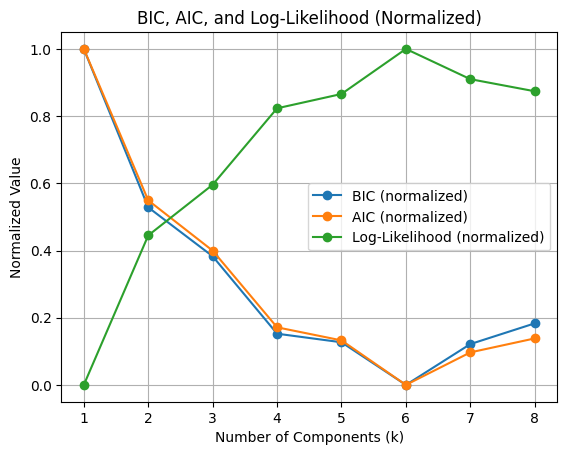

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

bic = []
aic = []
log_likelihood = []

Ks = range(1, 9)

for k in Ks:
    gmm = GaussianMixture(n_components=k, random_state=0)
    gmm.fit(Xs_sample)
    bic.append(gmm.bic(Xs_sample))
    aic.append(gmm.aic(Xs_sample))
    log_likelihood.append(gmm.score(Xs_sample))  # avg log-likelihood

# --- Normalize each metric using min-max ---
bic_norm = (np.array(bic) - np.min(bic)) / (np.max(bic) - np.min(bic))
aic_norm = (np.array(aic) - np.min(aic)) / (np.max(aic) - np.min(aic))
ll_norm  = (np.array(log_likelihood) - np.min(log_likelihood)) / (np.max(log_likelihood) - np.min(log_likelihood))

# --- Plot all on one chart ---
plt.plot(Ks, bic_norm, marker='o', label="BIC (normalized)")
plt.plot(Ks, aic_norm, marker='o', label="AIC (normalized)")
plt.plot(Ks, ll_norm, marker='o', label="Log-Likelihood (normalized)")

plt.xlabel("Number of Components (k)")
plt.ylabel("Normalized Value")
plt.title("BIC, AIC, and Log-Likelihood (Normalized)")
plt.legend()
plt.grid(True)
plt.show()


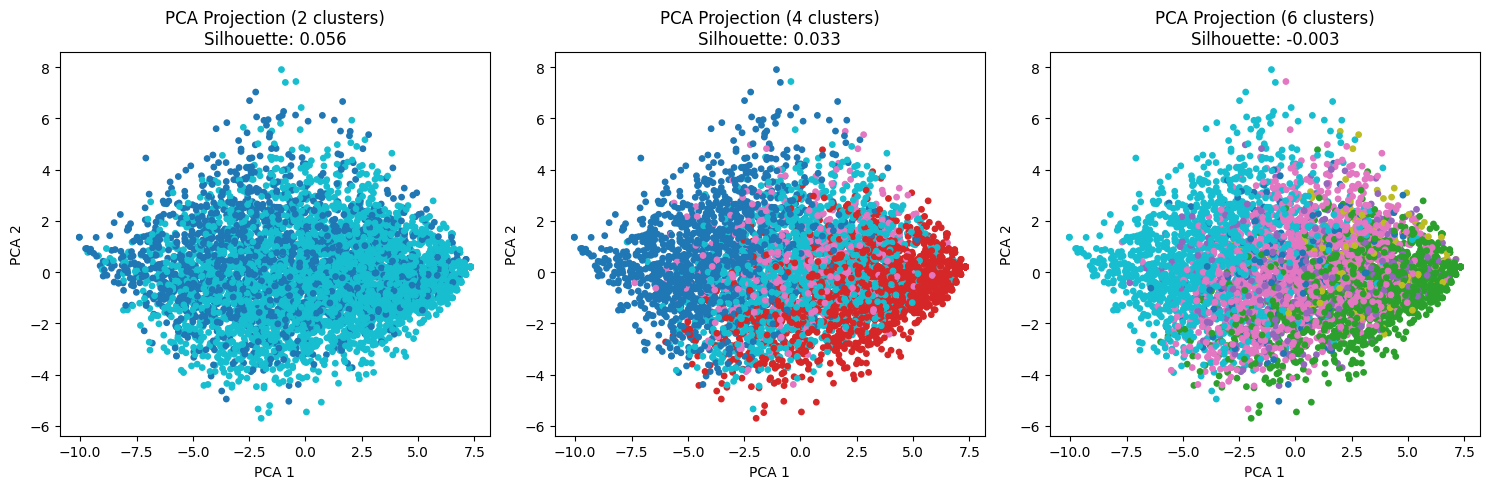

In [34]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(Xs_sample)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, k in enumerate([2, 4, 6]):
    gmm = GaussianMixture(n_components=k, random_state=0)
    labels = gmm.fit_predict(Xs_sample)
    score = silhouette_score(Xs_sample, labels)
    axes[i].scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap="tab10", s=15)
    axes[i].set_title(f"PCA Projection ({k} clusters)\nSilhouette: {score:.3f}")
    axes[i].set_xlabel("PCA 1")
    axes[i].set_ylabel("PCA 2")
plt.tight_layout()
plt.show()

# Analyze cluster mean responses

,Q1A,Q2A,Q3A,Q4A,Q5A,Q6A,Q7A,Q8A,Q9A,Q10A,Q11A,Q12A,Q13A,Q14A,Q15A,Q16A,Q17A,Q18A,Q19A,Q20A
Cluster,,,,,,,,,,,,,,,,,,,,
0,3.102273,3.204545,2.920455,2.920455,3.289773,2.625000,2.215909,3.017045,3.125000,3.289773,2.153409,3.369318,2.681818,2.187500,3.295455,2.823864,2.511364,3.397727,2.238636,2.403409
1,3.969970,3.958709,1.981231,2.086336,4.114865,1.569820,1.000000,3.659159,2.869369,2.331832,1.000000,4.254505,3.593844,1.570571,3.973724,1.835586,1.894144,4.193694,5.000000,2.879129
2,3.419283,3.488789,2.786996,2.717489,3.697309,2.381166,1.917040,3.049327,3.329596,2.903587,1.751121,3.753363,2.928251,2.107623,3.605381,2.399103,2.410314,3.802691,4.000000,2.372197
3,3.451505,3.368562,2.804682,2.701672,3.713043,2.498328,2.171906,3.137124,3.763880,3.149833,1.852174,3.868227,3.044816,1.970569,3.528428,2.311706,2.291639,3.745819,5.000000,2.436789
4,4.583851,4.099379,2.211180,2.018634,4.509317,1.850932,1.832298,3.838509,2.552795,2.155280,1.304348,4.677019,3.602484,1.509317,4.093168,2.080745,2.223602,4.136646,2.285714,3.086957
5,2.397842,2.498561,3.636691,3.570504,2.981295,3.840288,3.324460,2.574101,5.000000,4.055396,2.287770,2.896403,2.094245,2.797842,2.749640,3.450360,2.797122,2.694245,3.562590,1.914388


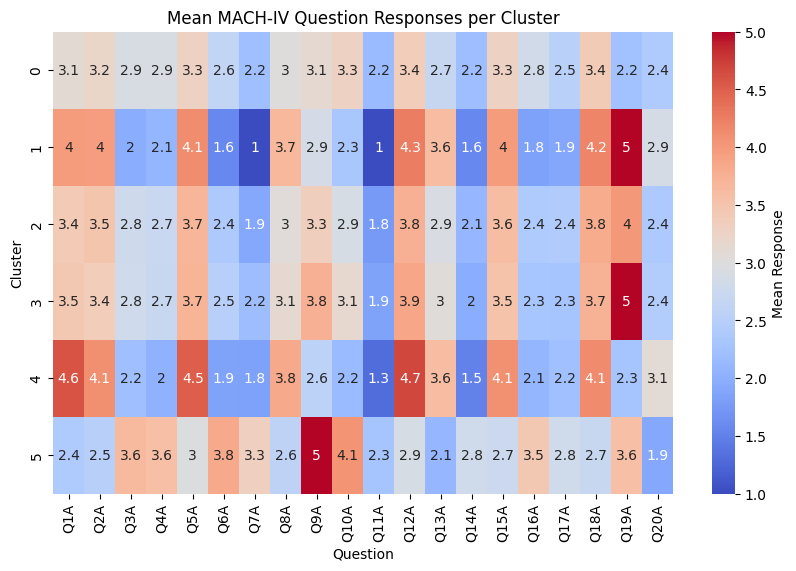

In [35]:
gmm = GaussianMixture(n_components=6, random_state=0)
labels = gmm.fit_predict(Xs_sample)
df = Xs_sample.copy()
df["Cluster"] = labels

cluster_means = df.groupby("Cluster").mean()
display(cluster_means)

plt.figure(figsize=(10, 6))
sns.heatmap(cluster_means, annot=True, cmap="coolwarm", cbar_kws={"label": "Mean Response"})
plt.title("Mean MACH-IV Question Responses per Cluster")
plt.xlabel("Question")
plt.ylabel("Cluster")
plt.show()

,Q1A,Q2A,Q3A,Q4A,Q5A,Q6A,Q7A,Q8A,Q9A,Q10A,Q11A,Q12A,Q13A,Q14A,Q15A,Q16A,Q17A,Q18A,Q19A,Q20A
Cluster,,,,,,,,,,,,,,,,,,,,
0,2,4,2,2,4,1,1,4,4,5,1,5,1,1,4,1,2,4,3,1
1,5,5,1,1,5,1,1,5,1,1,1,5,5,1,5,1,1,5,5,1
2,4,4,2,4,4,2,1,4,4,2,1,5,4,2,4,1,2,4,4,1
3,5,4,2,2,4,2,2,4,5,2,2,5,4,1,4,1,1,4,5,1
4,5,5,1,1,5,1,1,5,3,1,1,5,5,1,5,1,1,5,3,5
5,1,1,5,5,4,5,5,1,5,5,1,1,1,1,1,5,1,1,5,1


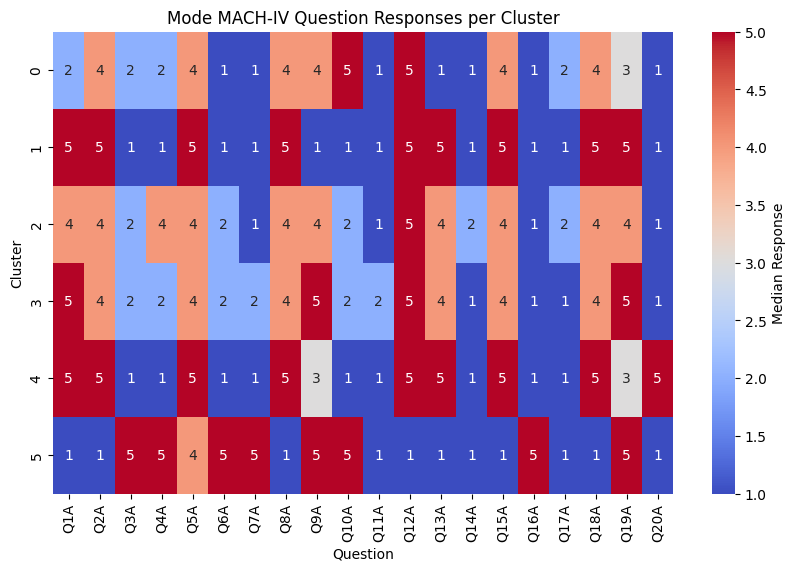

In [36]:
cluster_modes = df.groupby("Cluster")[question_responses] \
                  .agg(lambda x: x.mode().iloc[0]) # first mode
display(cluster_modes)

plt.figure(figsize=(10, 6))
sns.heatmap(cluster_modes, annot=True, cmap="coolwarm", cbar_kws={"label": "Median Response"})
plt.title("Mode MACH-IV Question Responses per Cluster")
plt.xlabel("Question")
plt.ylabel("Cluster")
plt.show()

# Check for patterns with other columns

In [40]:
other_responses = ["TIPI1","TIPI2","TIPI3","TIPI4","TIPI5","TIPI6","TIPI7","TIPI8","TIPI9","TIPI10",
                   "VCL1","VCL2","VCL3","VCL4","VCL5","VCL6","VCL7","VCL8","VCL9","VCL10", "VCL11","VCL12","VCL13","VCL14","VCL15", "VCL16",
                   "education", "urban", "gender", "engnat", "age", "hand", "religion", "orientation", "race", "voted", "married", "familysize", "major"]

# remove major for now
other_responses.remove("major")

,TIPI1,TIPI2,TIPI3,TIPI4,TIPI5,TIPI6,TIPI7,TIPI8,TIPI9,TIPI10,...,gender,engnat,age,hand,religion,orientation,race,voted,married,familysize
Cluster,,,,,,,,,,,,,,,,,,,,,
0.0,0.590097,0.622565,0.682630,0.579545,0.770292,0.637987,0.707792,0.525974,0.627435,0.388799,...,0.464015,0.752841,0.005695,0.410985,0.476799,0.253409,0.637175,0.823864,0.409091,0.110795
0.2,0.558237,0.722222,0.718576,0.533677,0.814136,0.636315,0.603925,0.528636,0.671171,0.355212,...,0.453453,0.680556,0.000016,0.396396,0.313001,0.283483,0.751609,0.782282,0.416416,0.102822
0.4,0.562140,0.643498,0.702434,0.550929,0.793722,0.658873,0.681935,0.520500,0.674568,0.399423,...,0.479821,0.732063,0.000014,0.377429,0.366779,0.254709,0.706278,0.755605,0.415546,0.102205
0.6,0.553177,0.654754,0.737315,0.585380,0.794267,0.658098,0.702532,0.511706,0.658385,0.385571,...,0.484504,0.702007,0.000015,0.392419,0.353623,0.275585,0.719350,0.778261,0.439019,0.101644
0.8,0.565217,0.677906,0.699201,0.582964,0.748891,0.686779,0.628217,0.514641,0.687666,0.389530,...,0.428571,0.763975,0.000015,0.407867,0.441511,0.249689,0.622005,0.801242,0.428571,0.114389
1.0,0.619630,0.540185,0.771942,0.579445,0.829394,0.650257,0.825283,0.459609,0.697945,0.373690,...,0.533573,0.662950,0.000020,0.379376,0.440647,0.259281,0.722302,0.738489,0.505516,0.115468


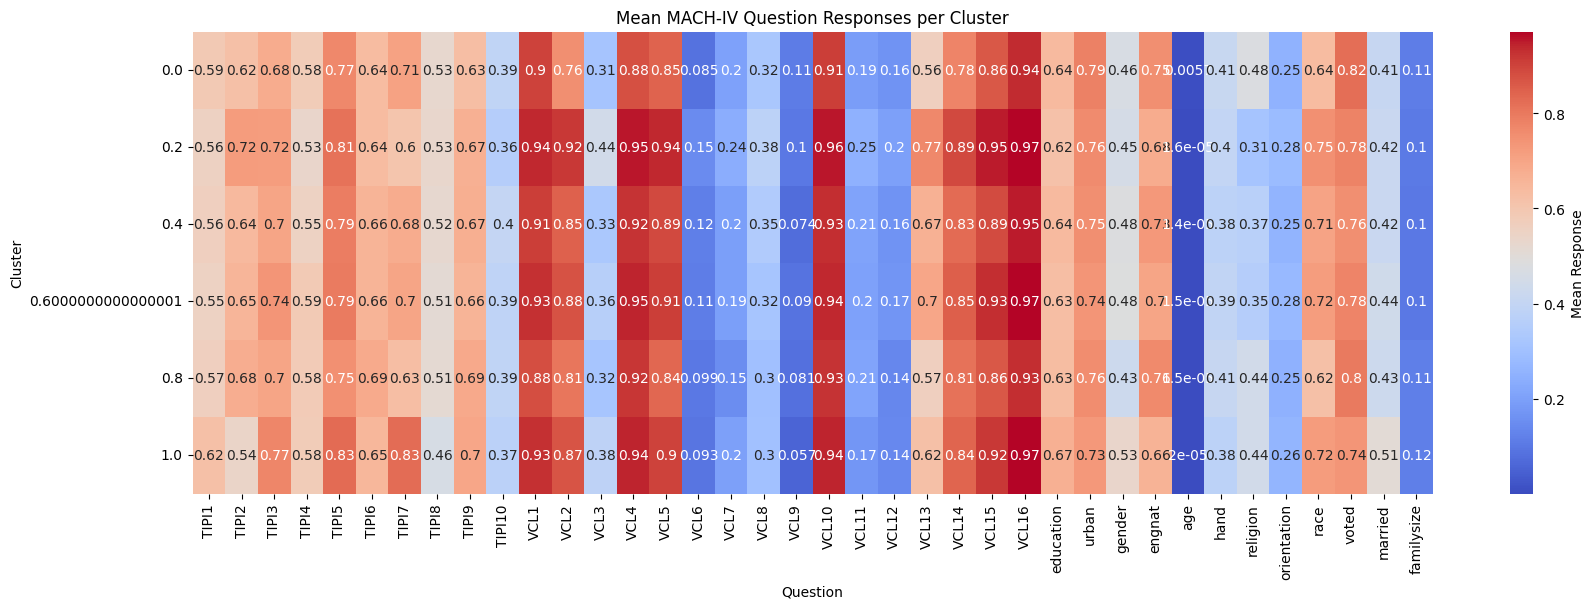

In [41]:
gmm = GaussianMixture(n_components=6, random_state=0)
labels = gmm.fit_predict(Xs_sample)
Xs_sample_with_other_responses = original_data_df.loc[Xs_sample.index]
df = pd.DataFrame(Xs_sample_with_other_responses, columns=other_responses, index=Xs_sample_with_other_responses.index)
df["Cluster"] = labels

scaler = MinMaxScaler()
normalized_df = pd.DataFrame(
    scaler.fit_transform(df),
    columns=df.columns,
    index=df.index
)

cluster_means = normalized_df.dropna().groupby("Cluster").mean()
display(cluster_means)

plt.figure(figsize=(20, 6))
sns.heatmap(cluster_means, annot=True, cmap="coolwarm", cbar_kws={"label": "Mean Response"})
plt.title("Mean MACH-IV Question Responses per Cluster")
plt.xlabel("Question")
plt.ylabel("Cluster")
plt.show()

,TIPI1,TIPI2,TIPI3,TIPI4,TIPI5,TIPI6,TIPI7,TIPI8,TIPI9,TIPI10,...,gender,engnat,age,hand,religion,orientation,race,voted,married,familysize
Cluster,,,,,,,,,,,,,,,,,,,,,
0.0,0.714286,0.714286,0.857143,0.285714,1.000000,0.857143,0.857143,0.714286,0.428571,0.142857,...,0.333333,1.0,0.000003,0.333333,0.583333,0.2,0.857143,1.0,0.333333,0.083333
0.2,0.857143,0.857143,1.000000,0.142857,1.000000,1.000000,0.714286,0.142857,1.000000,0.142857,...,0.333333,0.5,0.000005,0.333333,0.166667,0.2,0.857143,1.0,0.333333,0.083333
0.4,0.857143,0.714286,0.857143,0.714286,0.857143,0.714286,0.714286,0.714286,0.857143,0.285714,...,0.333333,0.5,0.000006,0.333333,0.083333,0.2,0.857143,1.0,0.333333,0.083333
0.6,0.285714,0.714286,0.857143,0.714286,1.000000,1.000000,0.714286,0.714286,0.857143,0.142857,...,0.333333,0.5,0.000005,0.333333,0.166667,0.2,0.857143,1.0,0.333333,0.083333
0.8,0.857143,0.714286,0.857143,0.714286,1.000000,1.000000,0.714286,0.285714,0.857143,0.142857,...,0.333333,1.0,0.000005,0.333333,0.333333,0.2,0.857143,1.0,0.333333,0.083333
1.0,0.857143,0.714286,0.857143,0.714286,1.000000,0.857143,1.000000,0.142857,0.857143,0.142857,...,0.666667,0.5,0.000008,0.333333,0.333333,0.2,0.857143,0.5,0.333333,0.083333


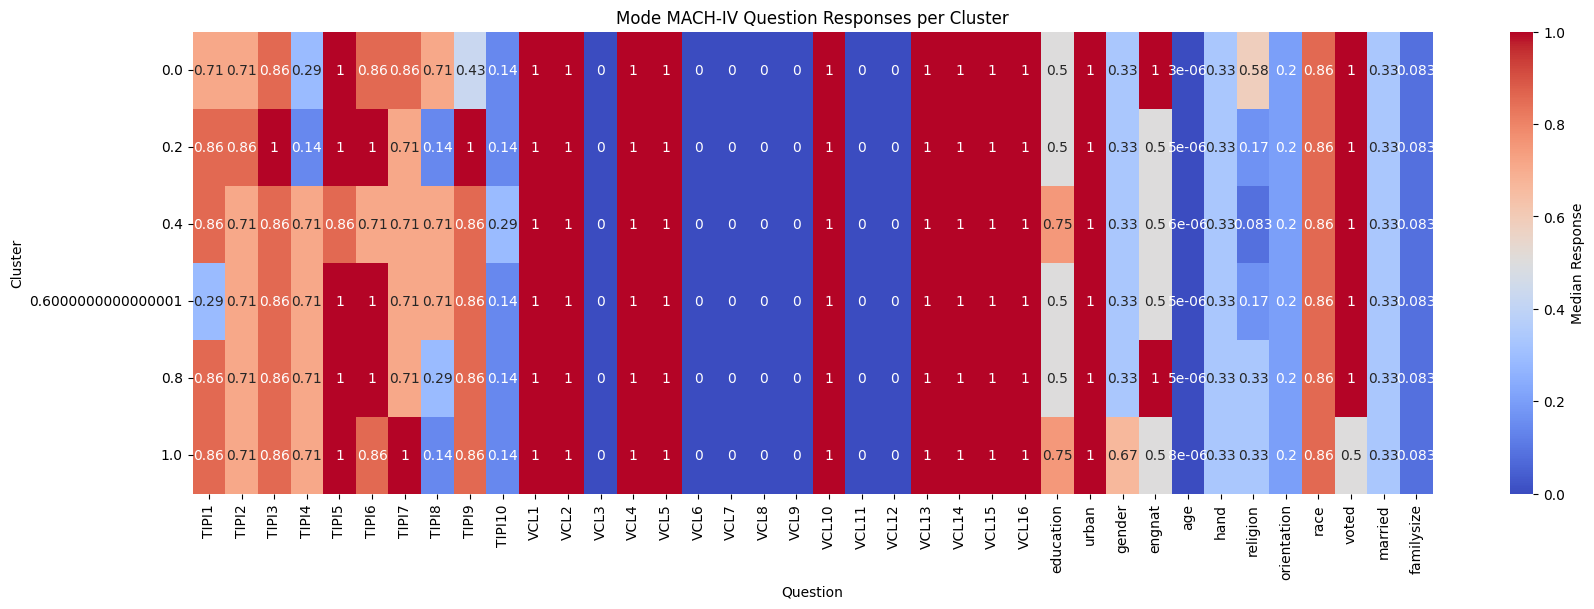

In [42]:
cluster_modes = normalized_df.groupby("Cluster")[other_responses] \
                  .agg(lambda x: x.mode().iloc[0]) # first mode
display(cluster_modes)

plt.figure(figsize=(20, 6))
sns.heatmap(cluster_modes, annot=True, cmap="coolwarm", cbar_kws={"label": "Median Response"})
plt.title("Mode MACH-IV Question Responses per Cluster")
plt.xlabel("Question")
plt.ylabel("Cluster")
plt.show()